<a href="https://colab.research.google.com/github/jaeheonk817/project_surface-crack-detection/blob/main/main_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

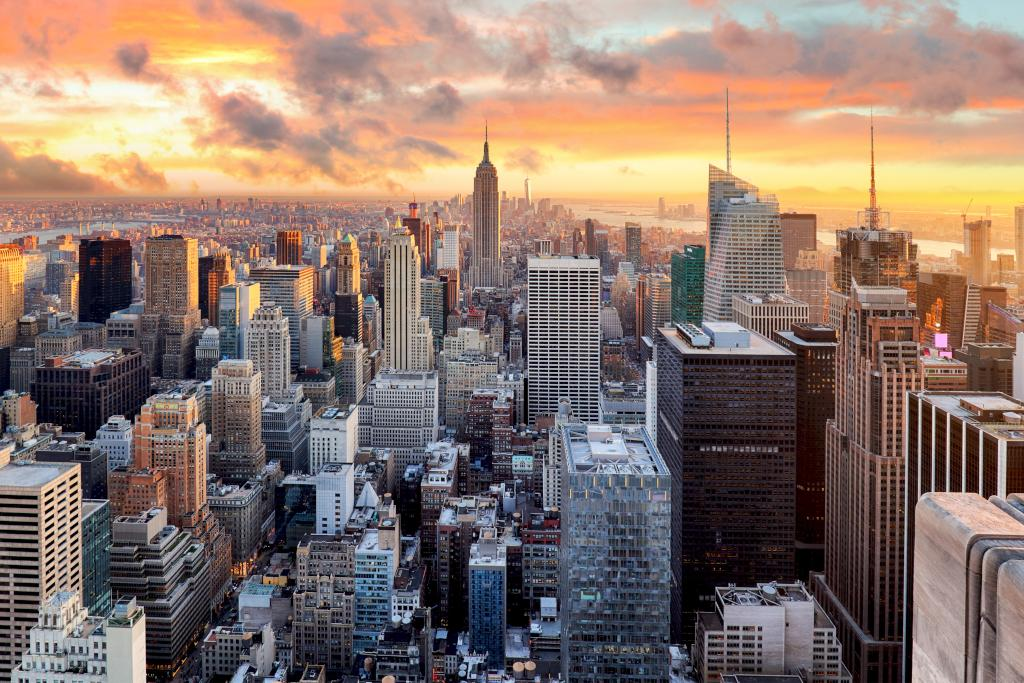

# Surface Crack Detection using CNN for NYC Department of Buildings
authored by Jae Heon Kim

## Overview
This data science project uses the CRISP-DM framework to develop a Convolutional Neural Network (CNN) model for classifying walls as either cracked or not-cracked based on image input. The project aims to provide an automated solution to identify areas for repair and maintenance in buildings. The steps involved include understanding the problem statement and defining the business goal, gathering and preparing the data, developing the model, evaluating its performance, and deploying it for use. The end result is a trained model that can accurately classify walls as cracked or not-cracked based on image input.

## Business Understanding
The stakeholder for this CRISP-DM data science project is the NYC Department of Buildings. The problem they face is that current inspection methods are outdated, costly, time-consuming, and less accurate due to human imperfections. This means that required inspections are not being completed on time, and there is a need for a more efficient and accurate solution. The stakeholder is interested in a model that can help digitize this inspection process, particularly with detecting building cracks. The goal of this project is to train a convolutional neural network (CNN) model that can accurately classify walls as cracked or not-cracked based on image input, thus providing a more automated and accurate solution for building inspections. By achieving this goal, the NYC Department of Buildings can improve the accuracy and efficiency of their inspection process, ultimately leading to cost savings and more timely inspections, which in turn can benefit and protect everyone living and working in New York City.

## Data Understanding
The dataset consists of 40,000 images of concrete surfaces with and without cracks, divided into two separate folders for negative (without crack) and positive (with crack) image classification. Each class has 20,000 images with a resolution of 227 x 227 pixels with RGB channels. The data is generated from 458 high-resolution images (4032x3024 pixel) using the method proposed by Zhang et al. (2016). No data augmentation in terms of random rotation or flipping or tilting is applied. The dataset is contributed by Çağlar Fırat Özgenel and was previously used in a study comparing the performance of pre-trained Convolutional Neural Networks (CNNs) on crack detection in buildings (Özgenel & Gönenç Sorguç, 2018). The dataset can be used for classifying crack and non-crack images and for creating a mask of the cracked portion in new images using image segmentation methods.

Source: https://www.kaggle.com/datasets/arunrk7/surface-crack-detection


The original data was located in a single directory with two categories: positive and negative. After reviewing the data, the data was randomly split into 80% for training, 10% for validation, and 10% for testing using sklearn's train test split. Substantial portion of data was allocated to the training set due to the data's richness, which still allows for good validation and testing sets at this ratio. The process is documented in the `data_prework.ipynb` notebook, which was kept separate from the main notebook to avoid unnecessary complexity and length.


To begin, we will make necessary imports, define relevant functions, and sample some images from the data to survey both cracked and uncracked walls. This will help us get an initial understanding of the data and prepare us for further analysis.

### Imports

In [2]:
# Import basic pacakges
import numpy as np
import pandas as pd

# Import visualization pacakges
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# # Import image processing packages
# from PIL import Image, ImageOps

# Import sklearn packages
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score

# Import tensorflow packages
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers import BatchNormalization, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2
from keras import regularizers
from keras.applications import VGG16
from keras.metrics import Precision, Recall

# Import miscellaneous packesgs
import os
import random

In [2]:
# # # Import image processing
# # from PIL import Image, ImageOps

# # Import tensorflow pacakges
# from tensorflow.keras.preprocessing.image import img_to_array
# from tensorflow.keras.utils import load_img, array_to_img
# from tensorflow.keras.models import load_model
# from tensorflow.keras.layers import Input
# from tensorflow.keras.layers import BatchNormalization, Activation
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from tensorflow.keras.regularizers import l2
# from tensorflow.keras import regularizers
# from tensorflow.keras.applications import VGG16
# from tensorflow.keras.metrics import Precision, Recall

# # Import miscellaneous packages
# import os
# import random
# import shutil

### Functions

In [3]:
# Define a function that plots training history of the model
def plot_training_history(model_history, model_name):
    """This function plots training history of the input model."""
    # Create a figure with two subplots
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,6))
    
    # Plot the training and validation loss in the first subplot
    ax0.plot(model_history.history['loss'], label='Training loss')
    ax0.plot(model_history.history['val_loss'], label='Validation loss')
    ax0.set_xlabel("Epochs")
    ax0.set_ylabel("Binary Cross Entropy")
    ax0.set_title('Training and Validation Loss')
    ax0.legend()
    
    # Plot the traning and validation recall in the first subplot
    ax1.plot(model_history.history['accuracy'], label='Training accuracy')
    ax1.plot(model_history.history['val_accuracy'], label='Validation accuracy')
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Accuracy")
    ax1.set_title('Training and Validation Accuracy')
    ax1.legend()
    
    # Set suptitle and plot
    plt.suptitle(f"Training History: {model_name}")
    plt.show()
    
    
    
# Define a function that will save model's metrics on test data
def save_model_metrics(model, model_name):
    """This function saves the model's metrics to a dictionary."""
    global test_data
    global model_results_dict
    
    # Make predictions on the test data
    y_pred_prob = model.predict(test_data)
    y_pred = np.round(y_pred_prob).flatten()

    # Get the true labels from the test data
    y_true = test_data.classes
    
    # Calculate accuracy, precision and recall
    accuracy = round(accuracy_score(y_true, y_pred), 3)
    recall = round(recall_score(y_true, y_pred), 3)
    precision = round(precision_score(y_true, y_pred), 3)

    # Store results to the dictionary
    model_results_dict['model'].append(model_name.title())
    model_results_dict['accuracy'].append(accuracy)
    model_results_dict['precision'].append(precision)
    model_results_dict['recall'].append(recall)



# Define a function that will print model's metrics on test data
def print_model_metrics(model, model_name):
    """This function prints the model's metrics."""
    global test_data
    
    # Make predictions on the test data
    y_pred_prob = model.predict(test_data)
    y_pred = np.round(y_pred_prob).flatten()

    # Get the true labels from the test data
    y_true = test_data.classes
    
    # Calculate accuracy, precision and recall
    accuracy = round(accuracy_score(y_true, y_pred), 3)
    recall = round(recall_score(y_true, y_pred), 3)
    precision = round(precision_score(y_true, y_pred), 3)

    # Print accuracy, precision and recall
    print(f"{model_name}'s accuracy: {accuracy}")
    print(f"{model_name}'s precision: {precision}")
    print(f"{model_name}'s recall: {recall}")

    
    
# Define a function that will plot model's confusion matrix based on its results on test data
def plot_confusion_matrix(model, model_name):
    """This function plots the confusion matrix of model's performance on the test data."""
    
    # Make predictions on the test data
    y_pred_prob = model.predict(test_data)
    y_pred = np.round(y_pred_prob).flatten()

    # Get the true labels from the test data
    y_true = test_data.classes
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Display the confusion matrix using ConfusionMatrixDisplay
    cmd = ConfusionMatrixDisplay(cm, display_labels=['No Crack', 'Crack'])
    cmd.plot(cmap='Blues')
    plt.ylabel("Actual Labels")
    plt.xlabel("Predicted Labels")
    plt.title(f"{model_name}'s Results on Test Data")
    plt.show()
    
    

# Define a function that will save the model to models directory
def save_model(model, model_name):
    """This function saves the trained model to a separate directory."""
    model.save(os.path.join('models', f"{model_name}.h5"))

### Observing Sample Data

In [4]:
# # Move to the root directory (if on google colab only)
# %cd /content/project_surface-crack-detection

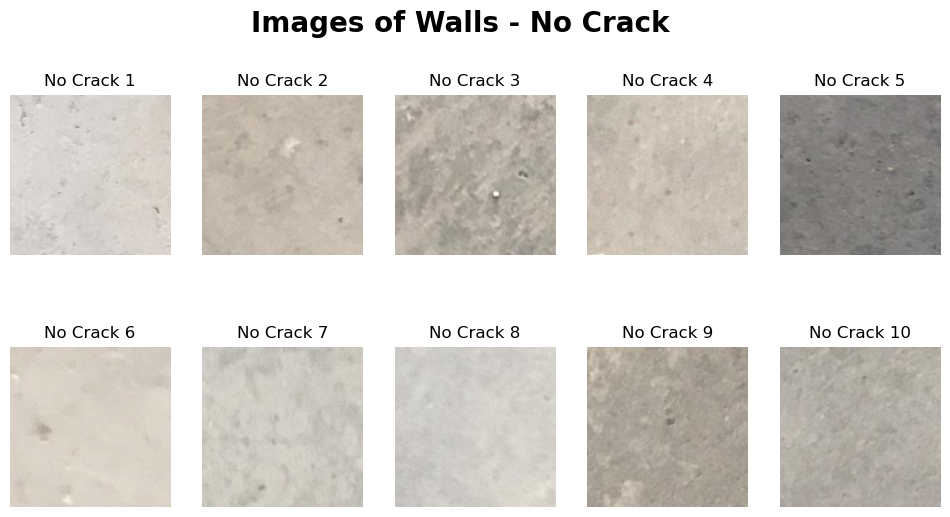

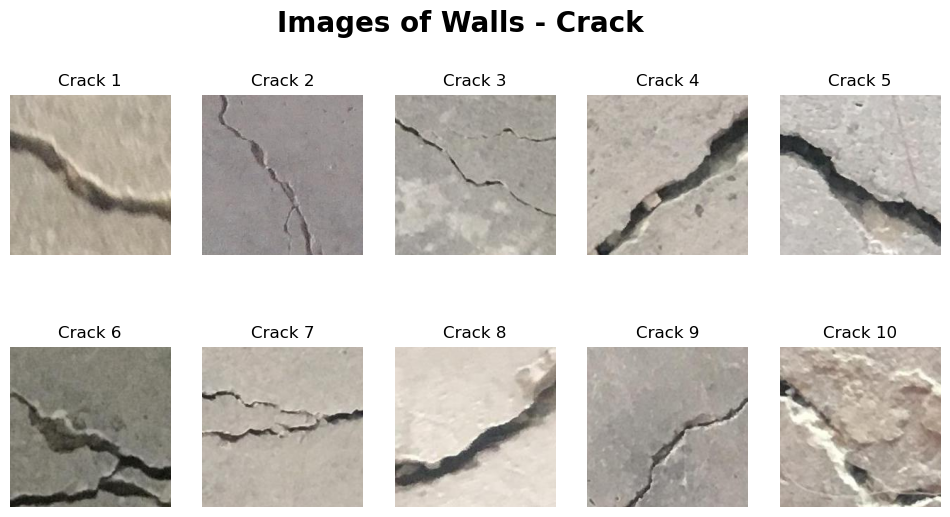

In [5]:
# # Assign directory paths to negative and positive data (if on google colab)
# negative_dir = '/content/project_surface-crack-detection/data/train/negative'
# positive_dir = '/content/project_surface-crack-detection/data/train/positive'

# Assign directory paths to negative and positive data (if on local jupyter notebook)
negative_dir = 'data/train/negative'
positive_dir = 'data/train/positive'

# Randomly pull fifteen negative images
negative_files = os.listdir(negative_dir)
random.shuffle(negative_files)
negative_files_random = negative_files[:15]

# Randomly pull fifteen positive images
positive_files = os.listdir(positive_dir)
random.shuffle(positive_files)
positive_files_random = positive_files[:15]

# Plot random negative images
fig, ax = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    row = i // 5
    col = i % 5
    image_path = os.path.join(negative_dir, negative_files_random[i])
    image = plt.imread(image_path)
    ax[row, col].imshow(image)
    ax[row, col].axis('off')
    ax[row, col].set_title(f'No Crack {i+1}')
plt.suptitle("Images of Walls - No Crack", fontsize=20, fontweight='bold')
plt.show()
print("\n"*5)

# Plot random positive images
fig, ax = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    row = i // 5
    col = i % 5
    image_path = os.path.join(positive_dir, positive_files_random[i])
    image = plt.imread(image_path)
    ax[row, col].imshow(image)
    ax[row, col].axis('off')
    ax[row, col].set_title(f'Crack {i+1}')
plt.suptitle("Images of Walls - Crack", fontsize=20, fontweight='bold')
plt.show()

- Some no-crack images have patterns that the model can mis interpret as cracks.
- Some crack images have very thin cracks that the model can mistake for a lined pattern.

While most images are easily distinguishable there are some images on the borderline that are difficult to calssify.

## Data Preparation

This section aims to provide a comprehensive overview of data processing techniques that are applicable to all models. However, since we intend to perform specific data processing for each model based on the knowledge gained from the previous one, this section will be brief and straightforward. As we proceed with each model, we can explore and apply more advanced data processing techniques that are tailored to the specific requirements of the model.

### Creating Train, Validation and Test Sets

As explained in `Data Understanding` section earlier, the original data was splitted into three subsets. The work can be found in `data_prework.ipynb` in the root directory. 

### Assinging Paths to Directories: If on Google Colab

In [6]:
# # Assign paths to directories
# train_dir = '/content/project_surface-crack-detection/data/train'
# val_dir = '/content/project_surface-crack-detection/data/val'
# test_dir = '/content/project_surface-crack-detection/data/test'

# # Assign paths to train directories
# train_negative_dir = '/content/project_surface-crack-detection/data/train/negative'
# train_positive_dir = '/content/project_surface-crack-detection/data/train/positive'

# # Assign paths to validation directories
# val_negative_dir = '/content/project_surface-crack-detection/data/val/negative'
# val_positive_dir = '/content/project_surface-crack-detection/data/val/positive'

# # Assign paths to test directories
# train_negative_dir = '/content/project_surface-crack-detection/data/test/negative'
# train_positive_dir = '/content/project_surface-crack-detection/data/test/positive'

### Assinging Paths to Directories: If on Local Jupupyter Notebook

In [4]:
# Assign paths to directories
train_dir = 'data/train'
val_dir = 'data/val'
test_dir = 'data/test'

# Assign paths to train directories
train_negative_dir = 'data/train/negative'
train_positive_dir = 'data/train/positive'

# Assign paths to validation directories
val_negative_dir = 'data/val/negative'
val_positive_dir = 'data/val/positive'

# Assign paths to test directories
train_negative_dir = 'data/test/negative'
train_positive_dir = 'data/test/positive'

### Creating Image Data Generators

We will now create a simple, normalized-pixel data generator that we will use for our future models.

In [5]:
# Define data generators with pixel normalization
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

## Modeling

It's finally some time for modeling. Our baseline model will be a cnn model with a single flatten hidden layer. Subsequent models will get more complicated with fine-tuning and other techniques associated with deep-learning image processing. We will save every model and and its metrics. The metrics will be used for comparison choose a final model and we will call back on the saved final model for deployment.

Before modeling, we will first create means to store our model and results so that they can be pulled later for comparison and deployment.

### Creating Directory and Dictionary to Save Models

#### Creating a Directory to Save Trained Models

In [14]:
# # Create a directory to save trained models
# os.makedirs('models')

#### Creating Dictionary to Save Model Metrics

In [7]:
# Create a dictionary to store each model's results
model_results_dict = {'model':[],
                      'accuracy':[],
                      'precision':[],
                      'recall':[]}

### Baseline Model: CNN with One Hidden Layer 
This model is a convolutional neural network with single flatten hidden layer. This model will take a grayscale image and run 3 epochs.

In [8]:
# Define train_data
train_data = train_datagen.flow_from_directory(train_dir, 
                                               target_size=(128, 128), 
                                               batch_size=128, 
                                               color_mode='grayscale',
                                               class_mode='binary', 
                                               classes=['negative', 'positive'])

# Define val_data
val_data = val_datagen.flow_from_directory(val_dir,
                                           target_size=(128, 128), 
                                           batch_size=128, 
                                           color_mode='grayscale',
                                           class_mode='binary', 
                                           classes=['negative', 'positive'],
                                           shuffle=False)

# Define test_data
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(128, 128), 
                                             batch_size=128, 
                                             color_mode='grayscale',
                                             class_mode='binary', 
                                             classes=['negative', 'positive'],
                                             shuffle=False)

Found 32000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


In [9]:
# Define the model
model_1 = Sequential()
    
# Define layers
model_1.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 1)))
model_1.add(Flatten())
model_1.add(Dense(1, activation='sigmoid'))

# Compile the model
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Recall()])

# Train the model
history_1 = model_1.fit(train_data, 
                        epochs=3, 
                        validation_data=val_data)

# Print model summary
model_1.summary()

Metal device set to: Apple M1


2023-04-09 09:46:11.303527: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-09 09:46:11.303866: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/3


2023-04-09 09:46:11.529724: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-09 09:46:11.889626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 0.7054 - accuracy: 0.8877 - recall: 0.8577

2023-04-09 09:46:45.817974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - 37s 144ms/step - loss: 0.7054 - accuracy: 0.8877 - recall: 0.8577 - val_loss: 0.1351 - val_accuracy: 0.9635 - val_recall: 0.9505
Epoch 2/3
250/250 [==============================] - 37s 146ms/step - loss: 0.1182 - accuracy: 0.9657 - recall: 0.9461 - val_loss: 0.0921 - val_accuracy: 0.9700 - val_recall: 0.9600
Epoch 3/3
250/250 [==============================] - 37s 147ms/step - loss: 0.0912 - accuracy: 0.9736 - recall: 0.9580 - val_loss: 0.0782 - val_accuracy: 0.9713 - val_recall: 0.9485
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 flatten (Flatten)           (None, 508032)            0         
                                                                 
 dense (Dense)               (None, 1)          

 3/32 [=>............................] - ETA: 1s

2023-04-09 09:49:04.747650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 2s 67ms/step


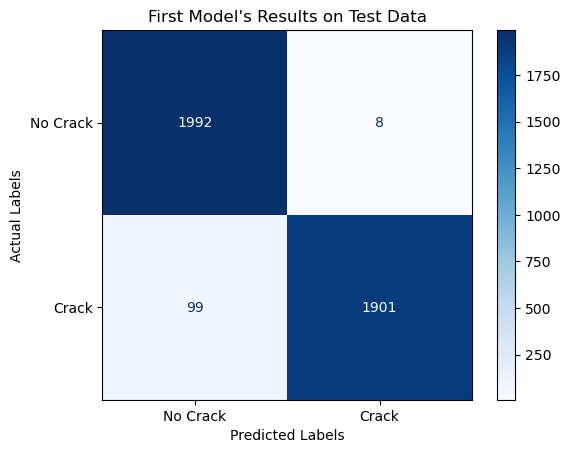

32/32 [==============================] - 2s 62ms/step
First Model's accuracy: 0.973
First Model's precision: 0.996
First Model's recall: 0.95


In [10]:
plot_confusion_matrix(model_1, "First Model")

print_model_metrics(model_1, "First Model")

In [11]:
save_model_metrics(model_1, "First Model")

save_model(model_1, "first_model")

32/32 [==============================] - 2s 75ms/step


About the First Model:
- This is our baseline model.

### Second Model

In [1]:
# Define train_data
train_data = train_datagen.flow_from_directory(train_dir, 
                                               target_size=(128, 128), 
                                               batch_size=128, 
                                               class_mode='binary', 
                                               classes=['negative', 'positive'])

# Define val_data
val_data = val_datagen.flow_from_directory(val_dir,
                                           target_size=(128, 128), 
                                           batch_size=128, 
                                           class_mode='binary', 
                                           classes=['negative', 'positive'],
                                           shuffle=False)

# Define test_data
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(128, 128), 
                                             batch_size=128, 
                                             class_mode='binary', 
                                             classes=['negative', 'positive'],
                                             shuffle=False)

NameError: name 'train_datagen' is not defined

In [ ]:
# Define the model
model_2 = Sequential()
    
# Define layers
model_2.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 1)))
model_2.add(Flatten())
model_2.add(Dense(1, activation='sigmoid'))

# Compile the model
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Recall()])

# Train the model
history_2 = model_1.fit(train_data, 
                        epochs=3, 
                        validation_data=val_data)

# Print model summary
model_2.summary()

Epoch 1/3


 3/32 [=>............................] - ETA: 1s

2023-04-08 16:58:00.575174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 2s 67ms/step


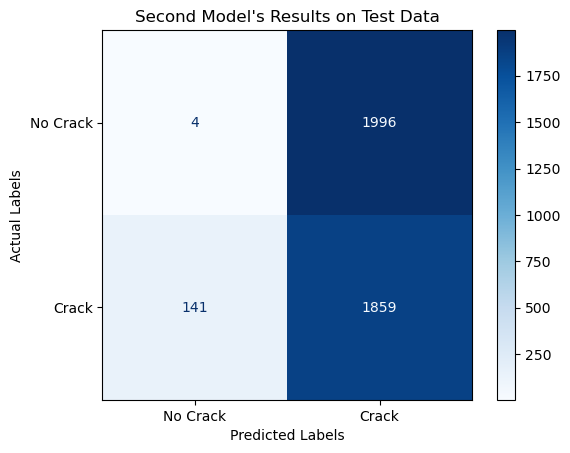

32/32 [==============================] - 2s 61ms/step
Second Model's accuracy: 0.466
Second Model's precision: 0.482
Second Model's recall: 0.93


In [55]:
plot_confusion_matrix(model_2, "Second Model")

print_model_metrics(model_2, "Second Model")

## Evaluation

## Conclusion

## Next Steps